In [11]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import unicodedata
from datetime import datetime

In [12]:
data = pd.read_csv('./readyToClassify.csv',sep=';')

In [13]:
data.head()

,Identificacion,Id_Estancia,Evolucion,Diagnostico,set
0,6512,40551,PACINETE QUIEN SE ENCUENTRA CON CUADRO CLINICO...,1.0,train
1,6512,48953,MANUEL GUILLERMO BOLIVAR BOLIVARNota de Inbgre...,1.0,train
2,6512,54779,MANUEL GUILLERMO BOLIVAR BOLIVARINGRESO UCI NE...,1.0,train
3,34256,45181,PACIENTE CON HC Y DX ANOTADOS. INGRESA A LA UN...,1.0,test
4,38177,45032,"PACIENTE CURSANDO CON BLOQUEO AV COMPLETO, SIN...",0.0,train


In [21]:
#limpieza
def normunicode_data(string):
    '''
     Normalise (normalize) unicode data in Python to remove umlauts, accents etc.
    '''
    #print(strin)
    return unicodedata.normalize('NFKD', string).encode('ASCII', 'ignore').decode("utf-8").lower()


def probability_of_disease(diagnosis, dic):
    '''
    input:  diagnosis: (str) diagnosis patient
            dic: (list)  keywords of certain disease
            name: (str) name of disease
    output: value between 0 and 1 according to probability of disease
    '''
    occurr = 0
    freq = 0
    list_diagnosis = normunicode_data(diagnosis).split()  # split string values
    len_diagnosis = len(list_diagnosis)
    len_vocabulary = len(dic)
    for token in dic:  # len(dic) iterations
        if any(token in word for word in list_diagnosis):
            occurr += 1
        freq += normunicode_data(diagnosis).count(token)

    # metrics
    # ocurrence of one word in diagnosis
    # to be effective, delete words withouth clinical value
    # problematic when some word repeats
    prob_coronaria_g1_1 = round(occurr / len_diagnosis, 3)
    # ocurrence of one word in vocabulary
    prob_coronaria_g1_2 = round(100 * (occurr / len_vocabulary), 1)

    if occurr != 0:
        prob_cor1 = round((freq / occurr) * prob_coronaria_g1_1, 3)
        prob_cor2 = round((freq / occurr) * prob_coronaria_g1_2, 3)

    if occurr == 0:
        result = 0
    else:
        if prob_cor2 > 0.1:
            result = 1
        else:
            result = 0

    return pd.Series({'Ocurrencia': occurr, 'Frecuencia': freq, 'Porcentaje_palabras': prob_coronaria_g1_2})

In [115]:
dic = pd.read_csv('../../Data/dic_coronario_g1.csv')

In [116]:
dic = [x.lower() for x in list(dic.Nombre.unique())]

In [15]:
data['cleanEvolucion'] = data.apply(lambda row: normunicode_data(row.Evolucion) ,axis=1)


In [16]:
data.head()

,Identificacion,Id_Estancia,Evolucion,Diagnostico,set,cleanEvolucion
0,6512,40551,PACINETE QUIEN SE ENCUENTRA CON CUADRO CLINICO...,1.0,train,pacinete quien se encuentra con cuadro clinico...
1,6512,48953,MANUEL GUILLERMO BOLIVAR BOLIVARNota de Inbgre...,1.0,train,manuel guillermo bolivar bolivarnota de inbgre...
2,6512,54779,MANUEL GUILLERMO BOLIVAR BOLIVARINGRESO UCI NE...,1.0,train,manuel guillermo bolivar bolivaringreso uci ne...
3,34256,45181,PACIENTE CON HC Y DX ANOTADOS. INGRESA A LA UN...,1.0,test,paciente con hc y dx anotados. ingresa a la un...
4,38177,45032,"PACIENTE CURSANDO CON BLOQUEO AV COMPLETO, SIN...",0.0,train,"paciente cursando con bloqueo av completo, sin..."


In [117]:
# takes a little bit of time
data[['Ocurrencia','Frecuencia','Porcentaje_palabras']] = data.apply(lambda row: probability_of_disease(diagnosis=row['cleanEvolucion'], dic=dic),axis=1)


In [126]:
normedData = data.Frecuencia/len(dic)

In [127]:
normedData /= max(normedData)

In [130]:
probs = normedData[data.set == 'test']

In [131]:
anots = data[data.set=='test']['Diagnostico']

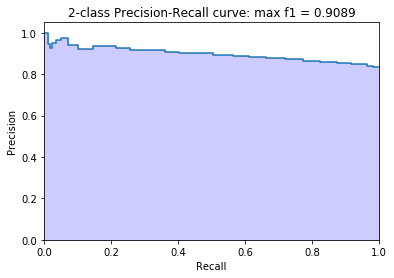

In [144]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(anots, probs)
f1 = 2*precision*recall/(precision+recall)
maxF1 = max(f1)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: max f1 = {:.4f}'.format(maxF1))
plt.savefig('./results/dictionaryClassification.png')

In [201]:

import sys
sys.path.insert(0, './models')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.externals import joblib
from MarisaTfidfVectorizer import *



best_params = {'f__k': 80000, 'v__max_features': 200000, 'v__ngram_range': (1, 6), 'c__alpha': 0.01}


In [202]:
pipe = Pipeline([
    ('v', TfidfVectorizer(
        ngram_range=best_params['v__ngram_range'], 
        max_features=best_params['v__max_features'])),
    ('f', SelectKBest(chi2, k=best_params['f__k'])),
    ('c', MultinomialNB(alpha=0.01))
])

In [203]:
pipe.fit(data[data.set=='train']['cleanEvolucion'],data[data.set=='train']['Diagnostico'])

Pipeline(memory=None,
     steps=[('v', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=200000, min_df=1,
        ngram_range=(1, 6), norm='l2', preprocessor=None, smooth_idf=True,
   ...ction chi2 at 0x7ff7a6cb6ae8>)), ('c', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])

In [204]:
hardPreds = pipe.predict(data[data.set=='test']['cleanEvolucion'])

In [205]:
probs = pipe.predict_proba(data[data.set=='test']['cleanEvolucion'])

In [206]:
probs = probs[:,1]

In [207]:
anots = data[data.set=='test']['Diagnostico']

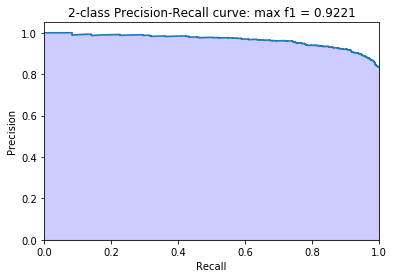

In [208]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(anots, probs)
f1 = 2*precision*recall/(precision+recall)
maxF1 = max(f1)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: max f1 = {:.4f}'.format(maxF1))
plt.savefig('./results/dictionaryClassification.png')